## Reviever

In [14]:

# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import time
import sys
import copy

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
import threading

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import newax25 as ax25

import multiprocessing

from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign
from queue import *

import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

import scipy
import zlib
from trans_utils import *
from proc_funs import *

%matplotlib inline

In [2]:
def queueREPLAY_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put( indata.copy()[:,0] )  # Global queue

In [3]:
sd.query_devices()

  0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 USB PnP Sound Device: Audio (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)

In [4]:
builtin_idx = 0
usb_idx = 2
sd.default.samplerate=48000
sd.default.channels = 1

## Calibrate Reciever and Mic Capture Volume 

In [8]:
Qin = Queue()

st = sd.Stream( device=(usb_idx, builtin_idx),callback=queueREPLAY_callback)

st.start()

# record and play about 10.6 seconds of audio 1000*512/48000 = 10.6 s
mxpwr = zeros(1000)
rmspwr = zeros(1000)

for n in range(0,1000):
    
    samples = Qin.get()
    mxpwr[n] = max(abs(samples))
    rmspwr[n] = np.sqrt(np.sum(np.square(samples)))
    # You can add code here to do processing on samples in chunks of 512 samples
    # In general, you will have to implement an overlap and add, or overlap an save to get
    # continuity between chunks -- we will do this later!
    
st.stop()
st.close()

# empty queue just in case there's something left
while not(Qin.empty()) :
    samples=Qin.get()

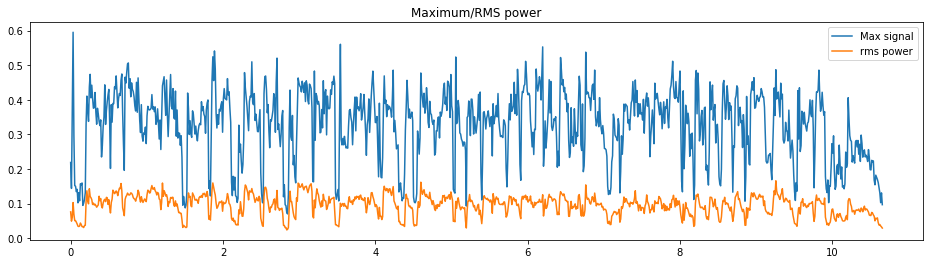

In [16]:
fig = plt.figure(figsize=(16,4))
t = r_[0:1000]*512/48000
plt.plot(t,mxpwr)
plt.plot(t,rmspwr/np.sqrt(512))
plt.title('Maximum/RMS power')
plt.legend(('Max signal','rms power'))

if any(mxpwr > 0.95):
    print("Warning! Signal is clipped. Reduce radio volume, and/or usb device input volume")
if max(mxpwr) < 0.3:
    print("Audio Volume may be too low. Increase the volume on the radio for better lab performance")

## Make Modem

Set up modem arguments

In [5]:
Abuffer = 512
Nchunks = 1
fs = 48000
modem = TNCaprs(fs = fs ,Abuffer = 512,Nchunks = 1)

## Reciever Set Up 

Set up reciever arguments

In [34]:
rec_time = 60
rec_img_f_name = 'rec_img.tiff'
exp_img_f_name = 'calBlue.tiff'
for_proc_fun, rev_proc_fun = no_proc()

## Begin Recieving

In [39]:
st_replay.stop()
st_replay.close()

In [40]:
st_replay = sd.Stream( device=(usb_idx, builtin_idx),callback=queueREPLAY_callback)
Qin = Queue()
print("Starting Reciving")
st_replay.start()
starttime = time.time()
time.sleep(rec_time)
st_replay.stop()
st_replay.close()
print("Done")
print(time.time() - starttime)

Starting Reciving
Done
60.06550645828247


## Image Reconstruction

Find packets and reconstruct compressed bit stream

In [41]:
print("decoding packets")
starttime = time.time()

# For you to complete
npack = 0
byte_packets = []
while Qin.qsize()>0:
    curr_samples = Qin.get()
    packets  = modem.processBuffer(curr_samples)
    for pkt in packets: 
        npack = npack + 1
        ax = modem.decodeAX25(pkt)
        infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
        print(infostr)
        byte_packets.append(ax.info)

rec_bytes = b''.join(byte_packets)
    
print(time.time() - starttime)


decoding packets
 1) | DEST: 1     0 | SRC:        | DIGI:       0 | b'x\x01\x8dZ\t\\\x94\xd5\xda?\xc3,\x0c\x0c3l\xc32\x80:\xa2 "*"\xab\x820\x1b\x03f\xeau\xa9\xf4\xb6!\x8cB\x82\xe0\x00\x96f\xd7%M\xbf\x96Om\xf1V\xe6\x12\xdaU\xcb2\xf3\xba\x8b0\xc3\xcc\xb0h7\xdb\xf3w\xcbl\xb1\xcc\xabV\xd72Y\xe7\xfe\x9f\xf7\x1d^F2M\xdf\xc6\xe7=\xefs\x9e\xf3?\xcf~\xce\xaf;\xefd\x89\x8ci\xb61\xa6\xbf\xed#\xee\xe5\t\x0f\xd4\xa9\x8862f\x1e\x91`\xa8} s\xd7\x13\xa3\x9d\x9b\x13\xde\xdf\xa9\xb5o\x8a\x7f\xb8d<c\xf9\x90\xe6\xdf\xcb\x7f[\xc9\xb7`\x10\xfd\t!<\xb0\x00\x89^\x13\x0cTX\xda8\xc5\x94\xb3\xfb\xc9\x91_\xbf\xa3\xe9r\xc8\xdd-\xcc\xdd\xca\xe8\xf7$\xebl\xf1[W\x9b\x02\x06\xb5\xd2\xf0g$\xf7\x03\xe6\xd3\x0b&D\xa1W\xcan\xaf1\x8e\xdf\x10\xa6\xd2+i\xa2)\'U\xf7\xfaS\xa3.5\xa8\x81\xc4\xedb\xdd6\x85\xdb%\x05\xb0n\xa7OW\x93\xaf\xfb_' |
 2) | DEST: 2     0 | SRC:        | DIGI:       0 | b"\xec\xb3=\x03\x98\x1cZ5\x85\x06\xdc^\xb876\x1eX\xb0B\xaf\t\xc4D\x03>\xa9\xff\x84\x04M\x08\xa1\xc2\xf3hq\xea\xf9\x83a\x00\x00<\xed\x8d\x0

 12) | DEST: 12    0 | SRC:        | DIGI:       0 | b"\xab\xd0-\xdf\x11\xf5B\x12\xd0\x9af\x9a\xb3\xaf\xd4SK\x89)X\x91\xd6\x05<\x14\xa0f\xc9\xa9\xedC\xe6\xdf;n\xaa!\xe7\xa9\xea\xd4/\xe1\xc9(\xdc\xad\x12\xb7S\xd9\xd9\x08xrJSMr\xac\xd8i'KqsI\xe7\x97\x8f\xaa][\x876m\x89C\x02G\xb2u;E]6\x15\x0c}\xfa\x1f\x83\x9e\xa8\xcc\xb8\x88j\x02\xaf\xab\x0f\x82\xb4\x7f\xed\xd2&\xc6\xd3\xc6U\\D\xf4;n\x84\x05\x00\xb9\xe9\x91\xb9\x99\xbfB\x0f\xad\x14\xe08\xc2`!\xca*\\\x1e\xb8f\x0b\xbc|$\xac\xd3)\x83n;\x9dJ\xdb\xd6\xb8o\x0f\xd1\xa1\x15.\r6<\xd7O`G\x14\x98H\xe0\xe8K1\x11F\xa7\xd7\x16\x11\x94\x832\rx]Nv\xe0\xd9a#\xe2\xe0`\x05\xcb\xca\xd2\xae5Q+\xde\x89\x82\xd2\xca>\xdf;\xa8l\x16\x0e\x8f\xc8\xcf\xf4\xf8\x91\x8d<z\x83\x93\x07I\xf0\x9a_\xf1\xd7q\xe7\xf6\xd1\xb9\t\xfc\xc8BP\x08\xba,\xba^\xc0*(\xc7m8" |
 13) | DEST: 13    0 | SRC:        | DIGI:       0 | b'\x00\x86m\xa8E\x9e,x\xbc"\xb5\x135\x1d7\x03\\e\xa7)\'\xd9\xf7G#\x7f\xb5\x07\x83p;}\x08\x9bSB\x13a\xc16vv\xdf\x80\xc7)\xcf\x00\x98qx\x0c\x19\xb1\xe6\xc1\xac/\xf7

## Perform Signal Reconstruction and Save Image

In [38]:
# Decompress bit stream
dec_bytes = zlib.decompress(rec_bytes)
rev_proc_fun(rec_img_f_name, dec_bytes)

error: Error -2 while preparing to decompress data: inconsistent stream state

Display reconstructed and expected images and show PSNR

Expected Image:
Recieved Image
PSNR:  inf


/home/pi/EE123/final_proj/trans_utils.py:505: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10*np.log10(maxVal**2.0/mse)


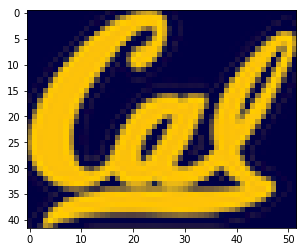

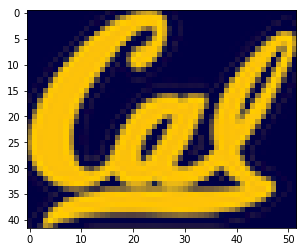

In [23]:
exp_img = scipy.ndimage.imread(rec_img_f_name)
rec_img = scipy.ndimage.imread(exp_img_f_name)
print('Expected Image:')
plt.figure()
plt.imshow(exp_img)
print('Recieved Image')
plt.figure()
plt.imshow(rec_img)
PSNR = EE123_psnr(exp_img, rec_img)
print("PSNR: ", PSNR)